In [1]:
import os
import pandas as pd
from tqdm import tqdm
import torch

from sklearn.metrics.pairwise import cosine_similarity
from rdkit.Chem import CanonSmiles, PandasTools, MolToSmiles

from mhfp.encoder import MHFPEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Disable warnings
from rdkit import RDLogger
import warnings

RDLogger.DisableLog("rdApp.*")
warnings.filterwarnings("ignore")
PandasTools.RenderImagesInAllDataFrames(images=True)

# Load model and training data

In [3]:
fingerprint_name = "mhfp6"
model_name = "rf"
model = torch.load(f"../models/combined/{fingerprint_name}_{model_name}.pkl")

In [4]:
training_df = pd.read_csv("../data/splits/combined/mhfp6_smote_train.csv")
training_df.head(2)

,bit0,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,bit9,...,bit2039,bit2040,bit2041,bit2042,bit2043,bit2044,bit2045,bit2046,bit2047,label
0,14433155,9273576,52428387,55778289,29319974,24922436,192953238,62403804,49040351,48020618,...,11055388,21431025,1416250,32703087,41181622,4925637,3638752,3279595,4090642,gram-positive
1,19469312,71257929,14316170,121213539,115681127,75668513,127870555,119200764,327151351,164407546,...,15596084,3736543,1416250,32970732,158260114,15628711,48984996,10981154,126156214,inactive


# Load testing data - Enamine Antibacterial Library

In [5]:
smiles_df = PandasTools.LoadSDF(
    "../data/benchmark/Enamine_Antibacterial_Library_32000cmpds_20231212.sdf"
)

In [6]:
smiles_df.shape

(32000, 11)

# Generate fingerprints

In [7]:
mhfp_encoder = MHFPEncoder(n_permutations=2048, seed=42)  # MHFP6 fingerprint

In [8]:
mhfp6_fingerprints = []

for mol in tqdm(smiles_df["ROMol"].values):
    # Generate the mol object
    smiles = MolToSmiles(mol)
    can_smiles = CanonSmiles(smiles)

    if not can_smiles:
        mhfp6_fingerprints.append(None)
        continue

    mhfp6_fingerprints.append(mhfp_encoder.encode(can_smiles, radius=3))


smiles_df[fingerprint_name] = mhfp6_fingerprints

100%|██████████| 32000/32000 [03:58<00:00, 134.31it/s]


# Performing predictions

In [9]:
predictions = model.predict(smiles_df[fingerprint_name].tolist())
prediction_proba = model.predict_proba(smiles_df[fingerprint_name].tolist())
label_classes = model.classes_.tolist()

In [10]:
smiles_df["Prediction"] = predictions

In [11]:
probs = []

for idx, probability in enumerate(prediction_proba):
    predicted_class = predictions[idx]
    probs.append(probability[label_classes.index(predicted_class)])

smiles_df["Probability"] = probs

# Looking at the predictions

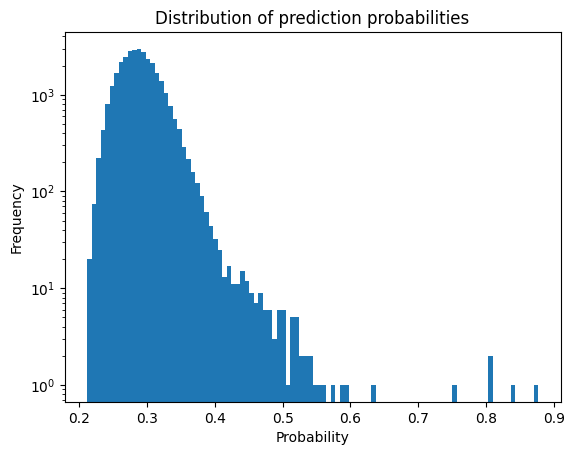

In [12]:
smiles_df["Probability"].plot(kind="hist", bins=100)
plt.yscale("log")
plt.xlabel("Probability")
plt.title("Distribution of prediction probabilities")
plt.show()

In [13]:
training_cmpds = []

for row in tqdm(training_df.values):
    cmpd_label = row[-1]
    cmpd_fingerprint = row[:-1]
    training_cmpds.append(cmpd_fingerprint)

100%|██████████| 105740/105740 [00:00<00:00, 1456193.93it/s]


In [14]:
cosine_df = cosine_similarity(mhfp6_fingerprints, training_cmpds)

In [15]:
max_similarity_scores = []

for sim_row in tqdm(cosine_df):
    max_similarity_scores.append(max(sim_row))

  0%|          | 0/32000 [00:00<?, ?it/s]

100%|██████████| 32000/32000 [05:02<00:00, 105.78it/s]


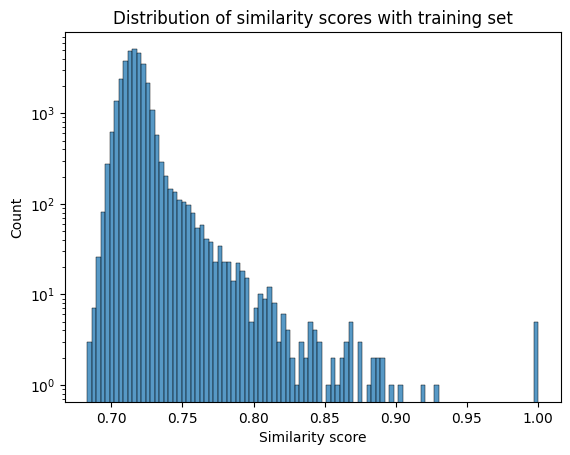

In [16]:
# Distribution of similarity scores with training set
sns.histplot(max_similarity_scores, bins=100)
plt.yscale("log")
plt.xlabel("Similarity score")
plt.title("Distribution of similarity scores with training set")
plt.show()

In [17]:
smiles_df["training_set_similarity"] = max_similarity_scores

In [18]:
smiles_df.sort_values("Probability", ascending=False, inplace=True)

In [19]:
smiles_df["training_set_similarity"].mean()

0.7178507370853935

# Saving the predictions

In [20]:
os.makedirs("../data/predictions", exist_ok=True)
smiles_df.to_csv(
    "../data/predictions/combined_enamine_antibacterial_predictions.csv", index=False
)

# Checking distribution of activity in Enamine library

In [21]:
k = smiles_df["Prediction"].value_counts().to_dict()
k

{'inactive': 28669,
 'gram-positive': 2276,
 'acid-fast': 719,
 'fungi': 192,
 'gram-negative': 144}

In [22]:
act_inact_dict = {
    "Active": sum([j for i, j in k.items() if i != "inactive"]),
    "Inactive": k["inactive"],
}

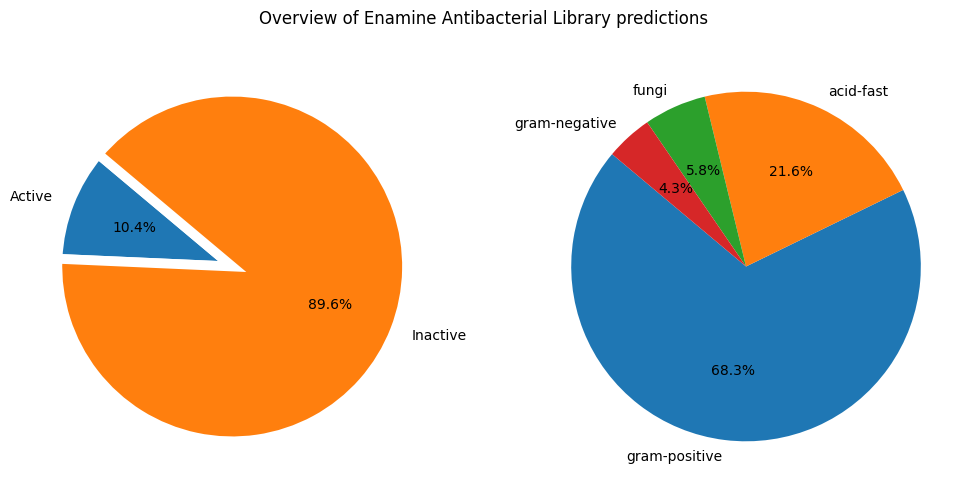

In [23]:
# Create a pieplot
plt.figure(figsize=(10, 5))
plt.suptitle("Overview of Enamine Antibacterial Library predictions")

ax1 = plt.subplot(121, aspect="equal")

plt.pie(
    act_inact_dict.values(),
    labels=act_inact_dict.keys(),
    autopct="%1.1f%%",
    startangle=140,
    wedgeprops={"linewidth": 7, "edgecolor": "white"},
)

ax2 = plt.subplot(122, aspect="equal")
act_only_dict = {k: v for k, v in k.items() if k != "inactive"}
plt.pie(
    act_only_dict.values(),
    labels=act_only_dict.keys(),
    autopct="%1.1f%%",
    startangle=140,
)
plt.tight_layout()
plt.savefig("../figures/figure_8.png", dpi=300)
plt.show()